### Time Series Decomposition
##### Decomposition is basically applied in time series analysis, it can also be used as a tool to inform forecasting models on a problem

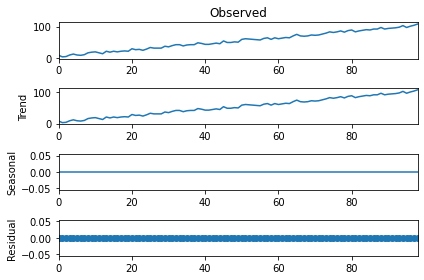

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from random import randrange
from pandas import Series
from matplotlib import pyplot
from statsmodels.tsa.seasonal import seasonal_decompose
series = [i+randrange(10) for i in range(1,100)]
# series = pd.read_csv("waterTankNew.csv", header=0, index_col=0).values
# result = seasonal_decompose(series, model='multiplicative', period=1)
result = seasonal_decompose(series, model='additive', period=1)
result.plot()
pyplot.show()

Differenced


<AxesSubplot:xlabel='time'>

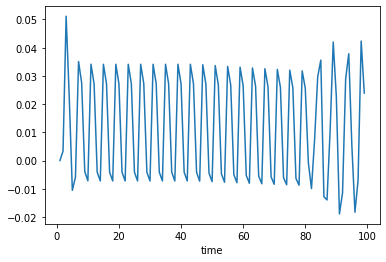

In [50]:
# Differencing
series = pd.read_csv("waterTankNew.csv", header=0, index_col=0)[0:100]
# series['Tank1WaterLevel'].dropna().plot()
series['Tank1WaterLevel_diff'] = series['Tank1WaterLevel'] - series['Tank1WaterLevel'].shift(1)
print("Differenced")
series['Tank1WaterLevel_diff'].dropna().plot()

### Test for Stationarity - constant mean and variance

In [47]:
import pandas as pd
from statsmodels.tsa.stattools import adfuller
# ADF Test - null hypothesis - non-stationary - if p-value < 5% reject null hypothesis
# adfuller_result = adfuller(series, autolag="AIC")
tankData = pd.read_csv("waterTankNew.csv", header=0, index_col=0)
attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
# adfuller_result = adfuller(tankData["wt3_valve"].values, autolag="AIC")

for feature in attr:
    
    adfuller_result = adfuller(tankData[feature].values, autolag="AIC")
    print("Stationarity metrics for each series")
    print(f'ADF Statistic: {adfuller_result[0]}')
    print(f'p-value: {adfuller_result[1]}')

    for key, value in adfuller_result[4].items():
        print('Critical Values: ')
        print(f'    {key}, {value}')

    print("Conclusion")
    if adfuller_result[1] > 0.05:
        print("Series is not stationary")
    else:
        print("Series is stationary")
    print("\n\n")

Stationarity metrics for each series
ADF Statistic: -10.822054077857318
p-value: 1.7952203957037132e-19
Critical Values: 
    1%, -3.430677760921837
Critical Values: 
    5%, -2.861684858789646
Critical Values: 
    10%, -2.56684710437876
Conclusion
Series is stationary



Stationarity metrics for each series
ADF Statistic: -8.445124611888938
p-value: 1.721056922432247e-13
Critical Values: 
    1%, -3.430677760921837
Critical Values: 
    5%, -2.861684858789646
Critical Values: 
    10%, -2.56684710437876
Conclusion
Series is stationary



Stationarity metrics for each series
ADF Statistic: -12.552326253149165
p-value: 2.192107228681411e-23
Critical Values: 
    1%, -3.430677760921837
Critical Values: 
    5%, -2.861684858789646
Critical Values: 
    10%, -2.56684710437876
Conclusion
Series is stationary



Stationarity metrics for each series
ADF Statistic: -10.547888979097348
p-value: 8.321350953780787e-19
Critical Values: 
    1%, -3.430677760921837
Critical Values: 
    5%, -2.8616

### How to make the time series stationary

### Forecasting fewer outputs with Enc-Dec LSTM

### visualise the data

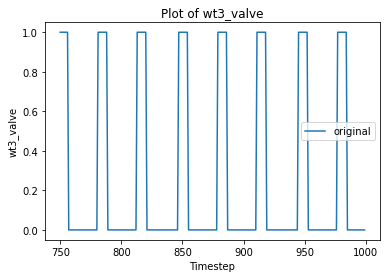

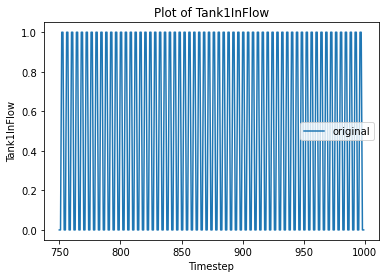

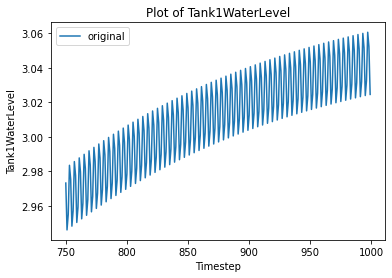

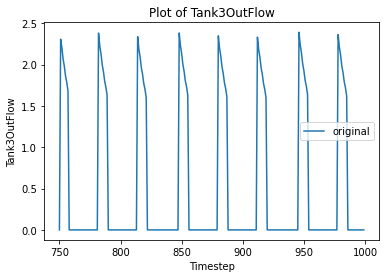

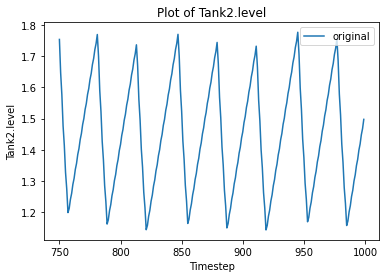

In [11]:
from pandas import read_csv
mydata = read_csv('waterTankNew.csv', header=0, index_col=0)

attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
for i in range(len(attr)):
    title = "Plot of "+str(attr[i])
#     actual = mydata.iloc[:2000,i]
    actual = mydata.iloc[750:1000,i]
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(attr[i])
    plt.plot(actual, label="original")
    plt.legend()
    plt.show()

The shape of the raw_data before scaling is (20001, 5)
Epoch 1/100
308/308 - 19s - loss: 0.1231 - 19s/epoch - 63ms/step
Epoch 2/100
308/308 - 17s - loss: 0.1047 - 17s/epoch - 56ms/step
Epoch 3/100
308/308 - 17s - loss: 0.0677 - 17s/epoch - 56ms/step
Epoch 4/100
308/308 - 17s - loss: 0.0631 - 17s/epoch - 56ms/step
Epoch 5/100
308/308 - 18s - loss: 0.0610 - 18s/epoch - 57ms/step
Epoch 6/100
308/308 - 17s - loss: 0.0602 - 17s/epoch - 56ms/step
Epoch 7/100
308/308 - 17s - loss: 0.0598 - 17s/epoch - 56ms/step
Epoch 8/100
308/308 - 17s - loss: 0.0591 - 17s/epoch - 57ms/step
Epoch 9/100
308/308 - 17s - loss: 0.0590 - 17s/epoch - 56ms/step
Epoch 10/100
308/308 - 17s - loss: 0.0590 - 17s/epoch - 57ms/step
Epoch 11/100
308/308 - 18s - loss: 0.0590 - 18s/epoch - 57ms/step
Epoch 12/100
308/308 - 18s - loss: 0.0594 - 18s/epoch - 57ms/step
Epoch 13/100
308/308 - 18s - loss: 0.0592 - 18s/epoch - 58ms/step
Epoch 14/100
308/308 - 18s - loss: 0.0594 - 18s/epoch - 58ms/step
Epoch 15/100
308/308 - 18s - l

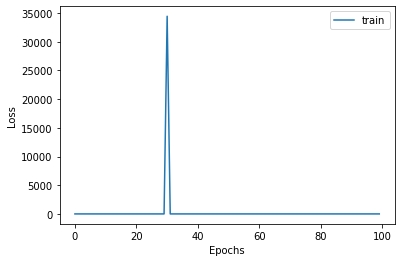

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_10 (LSTM)              (None, 50)                11200     
                                                                 
 repeat_vector_5 (RepeatVect  (None, 100, 50)          0         
 or)                                                             
                                                                 
 lstm_11 (LSTM)              (None, 100, 50)           20200     
                                                                 
 time_distributed_5 (TimeDis  (None, 100, 5)           255       
 tributed)                                                       
                                                                 
Total params: 31,655
Trainable params: 31,655
Non-trainable params: 0
_________________________________________________________________


In [51]:
# multivariate output stacked lstm example
import pandas as pd
from numpy import array
from numpy import hstack, vstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense, Bidirectional, RepeatVector, TimeDistributed
from keras.layers.core import Dropout
from sklearn.preprocessing import MinMaxScaler
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np



# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
    X, y = list(), list()
    for i in range(len(sequences)):
        # find the end of this pattern
        end_ix = i + n_steps_in
        out_end_ix = end_ix + n_steps_out
        # check if we are beyond the dataset
        if out_end_ix > len(sequences):
            break
        # gather input and output parts of the pattern
        seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

# define input sequence

# Read the data
# data = read_csv('waterTank.csv', header=0, index_col=0)
# data = read_csv('outputs.csv', header=0, index_col=0)
# data = read_csv('trig.csv', header=0, index_col=0)
data = read_csv('waterTankNew.csv', header=0, index_col=0)

# horizontally stack columns
raw_data = data.values
print(f'The shape of the raw_data before scaling is {raw_data.shape}')
#normalize input features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(raw_data)

n_train = 10000
dataset = scaled_data[0:n_train,:]
# choose a number of time steps
# n_steps_in, n_steps_out = 50, 100
n_steps_in, n_steps_out = 50, 100

# convert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(50, activation='relu', return_sequences=True))
# model.add(TimeDistributed(Dense(50, activation='relu')))
model.add(TimeDistributed(Dense(n_features)))
# model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
train_history = model.fit(X, y, epochs=100, verbose=2, shuffle=False)

# demonstrate Direct prediction
# x_inp = raw_data[n_train:n_train+n_steps,:]
x_inp = scaled_data[n_train:n_train+n_steps_in,:]
print(f'Initial shape of x_input {x_inp.shape}')
x_input = x_inp.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(f'The shape of yhat after prediction is {yhat.shape}')
yhat = yhat.reshape(n_steps_out, n_features)
print(f'The new shape of yhat  is {yhat.shape}')
inv_yhat = scaler.inverse_transform(yhat)
print(inv_yhat)

print("-------Learning Curve--------")
plt.plot(train_history.history['loss'], label='train')
# plt.plot(train_history.history['val_loss'], label='test')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

model.summary()

In [52]:
len(inv_yhat.T)

5

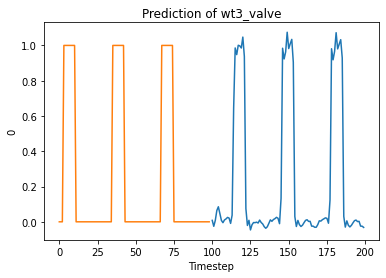

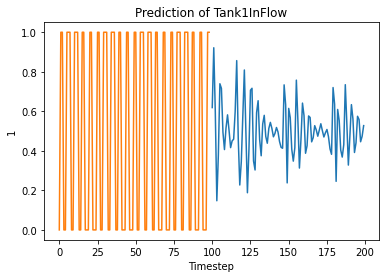

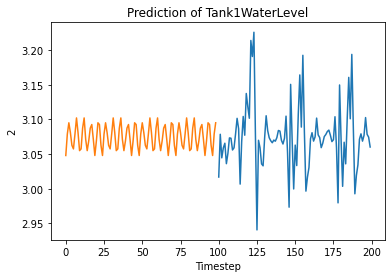

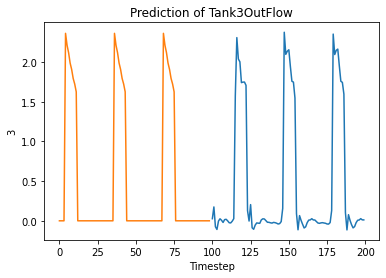

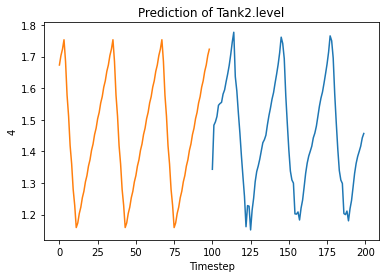

In [53]:
attr = len(inv_yhat.T)
attr = ["wt3_valve", "Tank1InFlow", "Tank1WaterLevel", "Tank3OutFlow", "Tank2.level"]
for i in range(len(attr)):
    title = "Prediction of "+str(attr[i])
    actual = raw_data[9901:10000,i]
    pred = inv_yhat.T
    pred_df = pd.DataFrame(inv_yhat)
    # specify the range based on the length of predicted output
    index = pd.Index(list(range(100,200)))
    pred_df = pred_df.set_index(index)
    plt.title(title)
    plt.xlabel("Timestep")
    plt.ylabel(i)
#     plt.plot(pred[i], label="predicted")
#     plt.plot(actual, label="actual")
    plt.plot(pred_df[i])
    plt.plot(actual)
    plt.show()

In [1]:
print("Welcome , H.B Adeyemo")

Welcome , H.B Adeyemo


### Forecasting fewer outputs with Enc-Dec GRU

### Fault Injection

In [ ]:
## Fault Injection
from pandas import read_csv
from random import randint
# from random import random
import random
import math


def inject_Fault_Univariate(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for i in range(len(data)):
        p = random.random()
        if p > 0.5:
            data["column"].iloc[i] += random.choice(fault_units)
            
    return data

def inject_Fault_Multivariate(data):
    n = len(data)
    fault_units = [-30.5, -20.5, 0, 15.5, 25.5]
    for col in data.columns:
        
        for i in range(len(data)):
            p = random.random()
            if p > 0.5:
                data[col].iloc[i] += random.choice(fault_units)

    return data


def value_flip(data, loc, col):
    for dp in data.index[loc]:
        if(data[col][dp] == 1):
            data[col][dp] = 0
        else:
            data[col][dp] = 1            
    return data

def stuck_at(data, loc, col, val):
    # This is either stuck_at zero or at 1
    for dp in data.index[loc]:
        data[col][dp] = val
    return data

def insert_outlier(data, col):
#     // This inserts at the beginning of the data
    maxi = data.describe()[col]["max"]
    mini = data.describe()[col]["min"]
    outlier = (maxi - mini)*50
    n = math.floor(len(data)*0.2)
    for i in range(len(data[col][0:n])):
        data[col].iloc[i] += outlier    
    return data

def stuck2_at(data, val, col, loc="beg"):
    # This is either stuck_at zero or at 1
    if(loc == "beg"):
        n = math.floor(len(data[col])*0.3)
        for i in range(n):
            data[col][i] = val
    return data



my_data = read_csv("waterTank.csv", header=0)
my_data = my_data.iloc[1:50,:]

# myNewdata = inject_Fault_Univariate(my_data)
myNewdata = inject_Fault_Multivariate(my_data)
myNewdata.to_csv("Randomized_data.csv")

flipped_data = bit_flip(my_data, "Tank1InFlow")
flipped_data.to_csv("flipped_data.csv")

outliered = insert_outlier(my_data, "Tank2WaterLevel")
outliered.to_csv("outlier_data.csv")

stuck_data = stuck_at(my_data, 1, "Tank1InFlow", loc="beg")
stuck_data.to_csv("stuck_at_one.csv")

print("Files saved successfully")

In [54]:
import pandas as pd
from numpy import array
from pandas import read_csv
from pandas import DataFrame
import matplotlib.pyplot as plt
import numpy as np


def value_flip(data, loc, col):
    for dp in data.index[loc]:
        if(data[col][dp] == 1):
            data[col][dp] = 0
        else:
            data[col][dp] = 1            
    return data


# mydata = read_csv('simulated_waterTank.csv', header=0, index_col=0, skiprows=4)
mydata = read_csv('waterTankNew.csv', header=0, index_col=0)
faulty_data = value_flip(mydata, range(100), "Tank1InFlow")
faulty_data
# mydata


C:\Users\user\AppData\Local\Temp\ipykernel_12588\3466033885.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][dp] = 1
C:\Users\user\AppData\Local\Temp\ipykernel_12588\3466033885.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[col][dp] = 0


,wt3_valve,Tank1InFlow,Tank1WaterLevel,Tank3OutFlow,Tank2.level
time,,,,,
0,0,1,1.000000e-06,0.0,0.000000
1,0,1,6.890000e-07,0.0,0.000000
2,0,0,3.333928e-03,0.0,0.000000
3,0,0,5.448433e-02,0.0,0.000000
4,0,1,7.717051e-02,0.0,0.000000
...,...,...,...,...,...
19996,0,1,3.078778e+00,0.0,1.233318
19997,0,1,3.095068e+00,0.0,1.253281
19998,0,0,3.081061e+00,0.0,1.283236


In [65]:
# newList = [x for x in mydata.iloc[range(5),0]]
result = [x for x in mydata.iloc[range(5),0]]
print(result)

[4, 0, 0, 0, 0]


In [1]:
print("Day")

Day
